In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from activ.pipeline import score_clusters
import matplotlib.pyplot as plt
import scipy
import h5py
from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as _sch
from collections import Counter
from activ import load_data
import pandas as pd
from math import ceil
import pandas as pd

In [2]:
fulldata = pd.read_csv('/Users/ahyeon/Desktop/TBIanalysis/data/preprocessed_data_matrix.csv', encoding = "ISO-8859-1")
fulldata = fulldata.fillna(-1)
fulldata.shape

(586, 919)

In [3]:
data = load_data()
nmfdata = load_data(uoinmf=True)

In [4]:
oc_features = data.outcome_features
oc_bases = nmfdata.outcome_bases
oc = data.outcomes
oc_bases.shape

(6, 177)

In [5]:
# GOSE scores
gose_needassistance_3m = oc[:,0]
gose_workresume_3m = oc[:,1]
gose_disruptrelation_3m = oc[:,2]
gose_otherissues_3m = oc[:,3]
gose_overallscore_3m = oc[:,4]
gose_Reponder6M_Patient_alone = oc[:,24]
gose_responder6m_patientplusrel = oc[:,25]
gose_needassistance_6m = oc[:,26]
gose_Travel6M = oc[:,27]
gose_socialresume_6m = oc[:,28]
gose_otherissues_6m = oc[:,29]
gose_epilepsy_6m = oc[:,30]
gose_epilepsyrisk_6m = oc[:,31]
gose_overallscore_6m = oc[:,32]

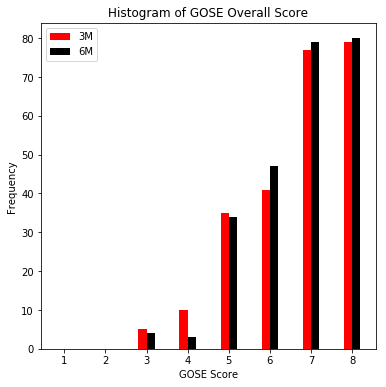

In [25]:
plt.subplots(figsize = (6,6))
plt.hist([gose_overallscore_3m, gose_overallscore_6m], align='left', bins=np.arange(1,9,0.5), label=['3M','6M'], color=['red','black'])
plt.title('Histogram of GOSE Overall Score')
plt.xlabel('GOSE Score')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('/Users/ahyeon/Desktop/activ misc/hist_gose1.pdf')

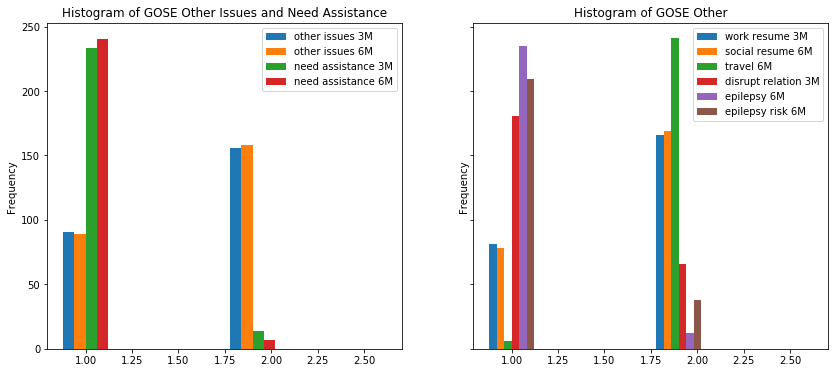

In [9]:
fig, (ax2, ax3) = plt.subplots(1,2, sharey=True, figsize=(14,6))

ax2.hist([gose_otherissues_3m, gose_otherissues_6m, gose_needassistance_3m,gose_needassistance_6m], bins=np.arange(1,3,0.3), align='left', label=['other issues 3M','other issues 6M', 'need assistance 3M', 'need assistance 6M'])
ax2.set_title('Histogram of GOSE Other Issues and Need Assistance')
# ax2.set_xlabel('GOSE Score')
ax2.set_ylabel('Frequency')
ax2.legend()

ax3.hist([gose_workresume_3m, gose_socialresume_6m, gose_Travel6M,gose_disruptrelation_3m,gose_epilepsy_6m,gose_epilepsyrisk_6m], bins=np.arange(1,3,0.3),
         align='left', label=['work resume 3M','social resume 6M', 'travel 6M','disrupt relation 3M','epilepsy 6M','epilepsy risk 6M'])
ax3.set_title('Histogram of GOSE Other')
# ax3.set_xlabel('GOSE Score')
ax3.set_ylabel('Frequency')
ax3.legend()
plt.savefig('/Users/ahyeon/Desktop/activ misc/hist_gose.pdf')

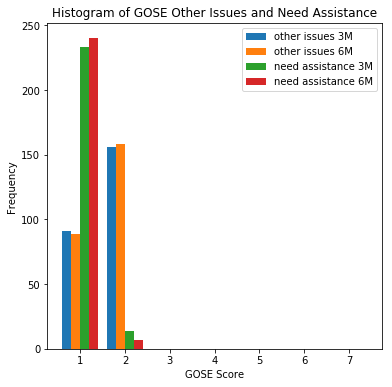

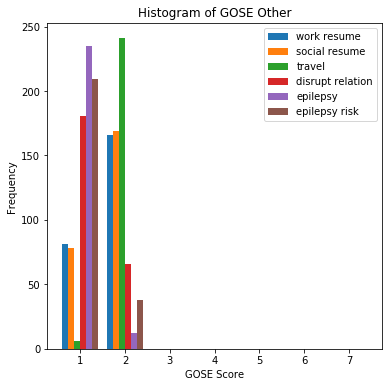

In [62]:
plt.figure(figsize=(6,6))

plt.hist([gose_otherissues_3m, gose_otherissues_6m, gose_needassistance_3m,gose_needassistance_6m], align='left', bins=np.arange(1,9,1), label=['other issues 3M','other issues 6M', 'need assistance 3M', 'need assistance 6M'])
plt.title('Histogram of GOSE Other Issues and Need Assistance')
plt.xlabel('GOSE Score')
plt.ylabel('Frequency')
plt.legend()

plt.figure(figsize=(6,6))
plt.hist([gose_workresume_3m, gose_socialresume_6m, gose_Travel6M,gose_disruptrelation_3m,gose_epilepsy_6m,gose_epilepsyrisk_6m], align='left', bins=np.arange(1,9,1), label=['work resume','social resume', 'travel','disrupt relation','epilepsy','epilepsy risk'])
plt.title('Histogram of GOSE Other')
plt.xlabel('GOSE Score')
plt.ylabel('Frequency')
plt.legend()


# plt.savefig('/Users/ahyeon/Desktop/activ misc/hist_gose.pdf')

In [6]:
file = '/Users/ahyeon/Desktop/activ misc/sweep_u2-10_c2-50_i50_raw-oc-cluster_uoinmf-bm-predict/umap_clustering_sweep.h5'

In [7]:
f = h5py.File(file, 'r')

In [8]:
umap_dims = f['umap_dimensions'][:]
score = f['score'][:]
norm_score = f['norm_score'][:]
clusters = f['clusters'][:]
cluster_sizes = f['cluster_sizes'][:]

In [9]:
emb = f['umap_embeddings'][:]
scale = f['umap_embeddings_dimscale'][:][:54]

In [10]:
for dim in umap_dims:
    all_dmat = np.zeros((30381,50))
    for x in range(emb.shape[0]):
        dmat = pdist(emb[x][:,scale==dim], metric='mahalanobis')
        all_dmat[:,x] = dmat
    mean = all_dmat.mean(axis=1)
mean.shape

(30381,)

In [11]:
def calc_entropy(gose_scores):
    probs = np.array(list(Counter(gose_scores).values()))/len(gose_scores)
    return entropy(probs, base=2.0)

In [12]:
def entropy_across_clusters(cluster_sizes, data):
    values = []
    tree = _sch.linkage(mean, method='ward')
    labels = _sch.cut_tree(tree, cluster_sizes)
    for ii,c in enumerate(cluster_sizes):
        entropies = []
        for label in np.unique(labels[:,ii]):
            scores = data[labels[:,ii]==label]
            ent = calc_entropy(scores)
            entropies.append(ent)
        v = np.mean(entropies)
        values.append(v)
    return values

In [12]:
gose_overallscore_3m.shape

(247,)

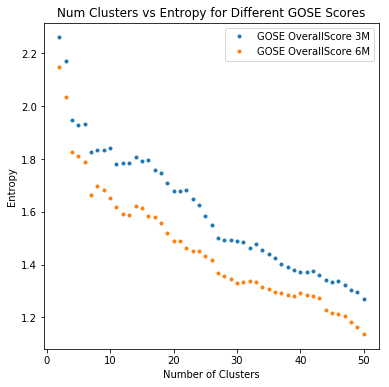

In [13]:
plt.figure(figsize=(6,6))
plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose_overallscore_3m), '.', label='GOSE OverallScore 3M')
plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose_overallscore_6m), '.', label='GOSE OverallScore 6M')
plt.xlabel('Number of Clusters')
plt.ylabel('Entropy')
plt.title('Num Clusters vs Entropy for Different GOSE Scores')
plt.legend() 
plt.savefig('/Users/ahyeon/Desktop/activ misc/gose_entropy.pdf')

In [13]:
# leverage scores
leveragescores = pd.read_csv('/Users/ahyeon/Desktop/activ misc/fullfeaturestable.csv', encoding = "ISO-8859-1")
scores = leveragescores['Leverage Score']
leveragescores
features = leveragescores['0%']


In [62]:
for ii,o in enumerate(oc_features):
    if 'GOSE' in o:
        

0 GOSE_NeedAssistance3M
1 GOSE_WorkResume3M
2 GOSE_DisruptRelation3M
3 GOSE_OtherIssues3M
4 GOSE_OverallScore3M
24 GOSE_Reponder6M_Patient.alone
25 GOSE_Reponder6M_Patient.plus.relative
26 GOSE_NeedAssistance6M
27 GOSE_Travel6M
28 GOSE_SocialResume6M
29 GOSE_OtherIssues6M
30 GOSE_Epilepsy6M
31 GOSE_EpilepsyRisk6M
32 GOSE_OverallScore6M


In [55]:
for feature,score in zip(features, scores):
    if 'GOSE' in feature:
        print(feature,score)
        

GOSE_OtherIssues6M 0.6597158387341439
GOSE_Reponder6M_Patient.alone 0.5486931296742804
GOSE_OtherIssues3M 0.536659584762919
GOSE_Travel6M 0.4996077495195704
GOSE_OverallScore3M 0.30611288418610155
GOSE_OverallScore6M 0.2933834452319081
GOSE_WorkResume3M 0.28722140616028
GOSE_SocialResume6M 0.2460432073480644
GOSE_DisruptRelation3M 0.24431980776823897
GOSE_EpilepsyRisk6M 0.1047700516420489
GOSE_NeedAssistance3M 0.07159706977424618
GOSE_Epilepsy6M 0.03827111901974863
GOSE_NeedAssistance6M 0.028884445676897637
GOSE_Reponder6M_Patient.plus.relative 0.011994125559458828


In [26]:
# gose
plt.figure(figsize=(6,6))
indices = [0,1,2,3,4,24,25,26,27,28,29,30,31,32]

for ii, ind in enumerate(indices):
    gose = oc[:,ind]
    name = oc_features[ind]
    score = float(round(oc_bases[:,ind].sum(axis=0),3))
    plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, gose), '.', label= name + ': ' + str(score))
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Entropy')
    plt.title('Num Clusters vs Entropy for GOSE Outcomes')
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5)) 
plt.savefig('/Users/ahyeon/Desktop/activ misc/gose_entropy.pdf',bbox_inches='tight')

TypeError: float() argument must be a string or a number, not 'function'

<Figure size 432x432 with 0 Axes>

In [25]:
# top 10
plt.figure(figsize=(6,6))

for ii,i in enumerate(features[:10]):
    data = oc[:,ii]
    score = float(round(scores[ii],3))
    plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, data), '.', label=i+ ': ' + str(score))
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Entropy')
    plt.title('Num Clusters vs Entropy for Top 10 Outcomes')
plt.savefig('/Users/ahyeon/Desktop/activ misc/top10_entropy.pdf',bbox_inches='tight')

TypeError: float() argument must be a string or a number, not 'function'

<Figure size 432x432 with 0 Axes>

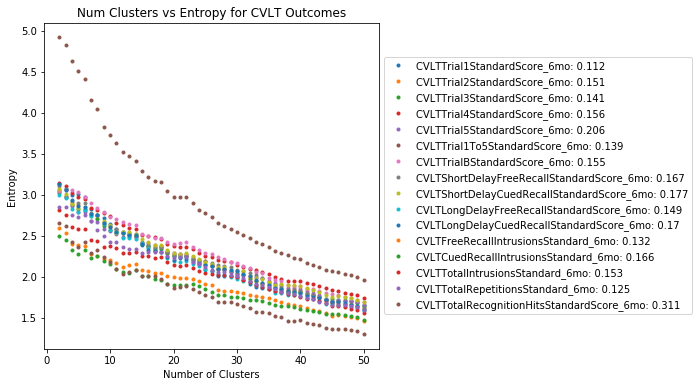

In [79]:
#cvlt
plt.figure(figsize=(6,6))

indices = [145,147,149,151,153,155,157,159,161,163,165,167,168,170,172,174]
cvlt_names = []
for ii, ind in enumerate(indices):
    cvlt = oc[:,ind]
    score = float(round(oc_bases[:,ind].sum(axis=0),3))
    name = oc_features[ind]
    cvlt_names.append(name)
    plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, cvlt), '.', label=cvlt_names[ii]+ ': ' + str(score))
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Entropy')
    plt.title('Num Clusters vs Entropy for CVLT Outcomes')
plt.savefig('/Users/ahyeon/Desktop/activ misc/cvlt_entropy.pdf',bbox_inches='tight')

In [106]:
for ii,feature in enumerate(oc_features):
    if 'CVLT' and 'Raw' in feature:
        print(feature,ii)

CVLTTrial1RawScore_6mo 144
CVLTTrial2RawScore_6mo 146
CVLTTrial3RawScore_6mo 148
CVLTTrial4RawScore_6mo 150
CVLTTrial5RawScore_6mo 152
CVLTTrial1To5RawScore_6mo 154
CVLTTrialBRawScore_6mo 156
CVLTShortDelayFreeRecallRawScore_6mo 158
CVLTShortDelayCuedRecallRawScore_6mo 160
CVLTLongDelayFreeRecallRawScore_6mo 162
CVLTLongDelayCuedRecallRawScore_6mo 164
CVLTFreeRecallIntrusionsRaw_6mo 166
CVLTTotalIntrusionsRaw_6mo 169
CVLTTotalRepetitionsRaw_6mo 171
CVLTTotalRecognitionHitsRawScore_6mo 173
CVLTTotalRecognitionDiscriminabilityRawScore_6mo 175


In [5]:
summaries = ['CVLTTrial1To5RawScore_6mo','CVLTTrialBRawScore_6mo','CVLTShortDelayFreeRecallRawScore_6mo',
            'CVLTLongDelayFreeRecallRawScore_6mo','CVLTTotalRecognitionDiscriminabilityRawScore_6mo','CVLTTotalIntrusionsRaw_6mo','CVLTTotalRepetitionsRaw_6mo']

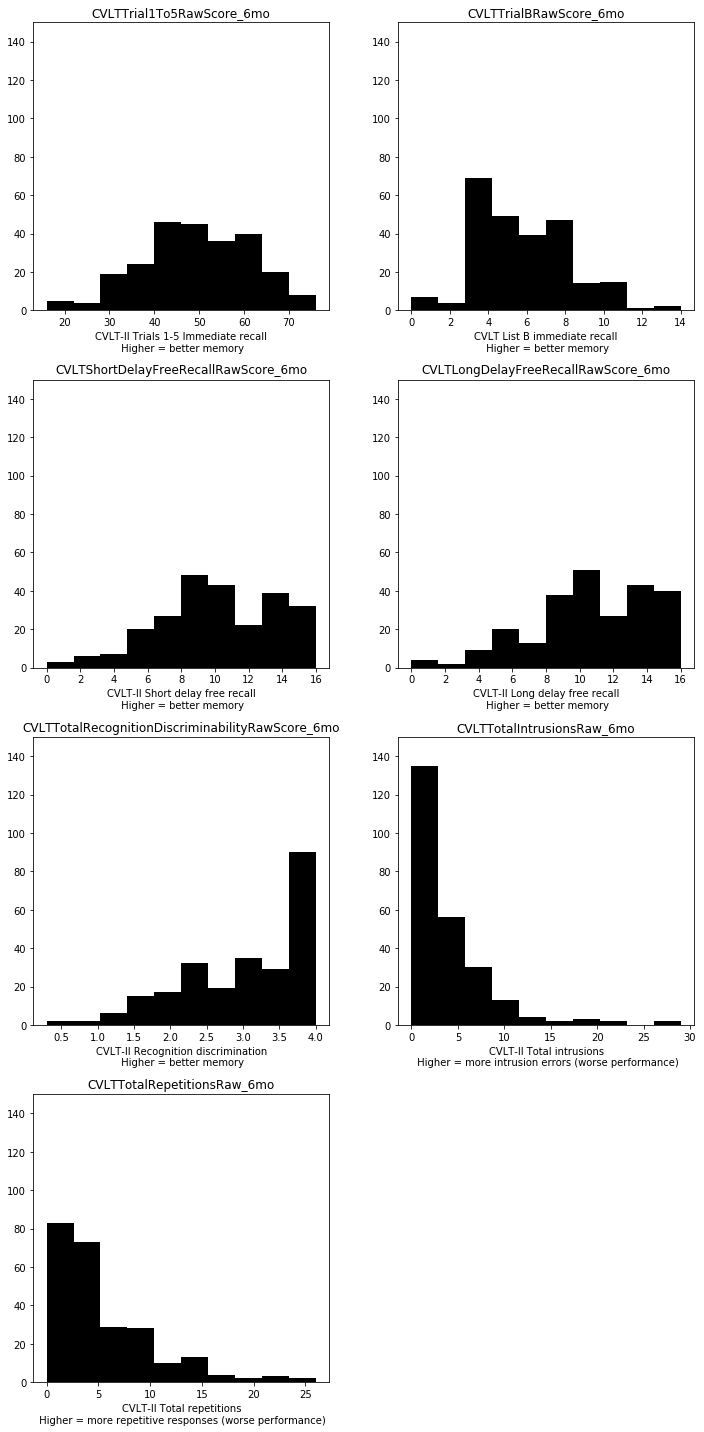

In [9]:
# CVLT summaries
indices = [154,156,158,162,175,169,171]
fullind = []
fig, ax = plt.subplots(4,2, figsize=(10,20))
ax = ax.flatten()

count = 0
for ind, feature in zip(indices, summaries):
    cvlt = oc[:,ind]
    ax[count].hist(cvlt, color='black')
    ax[count].set_title('{}'.format(feature))
    ax[count].set_ylim([0,150])
    ax[7].set_visible(False)
    ax[0].set_xlabel('CVLT-II Trials 1-5 Immediate recall\n Higher = better memory')
    ax[1].set_xlabel('CVLT List B immediate recall\n Higher = better memory')
    ax[2].set_xlabel('CVLT-II Short delay free recall\n Higher = better memory')
    ax[3].set_xlabel('CVLT-II Long delay free recall\n Higher = better memory')
    ax[4].set_xlabel('CVLT-II Recognition discrimination\n Higher = better memory')
    ax[5].set_xlabel('CVLT-II Total intrusions\n Higher = more intrusion errors (worse performance)')
    ax[6].set_xlabel('CVLT-II Total repetitions\n Higher = more repetitive responses (worse performance)')
    count += 1
fig.tight_layout()
plt.savefig('/Users/ahyeon/Desktop/activ misc/cvlt_summary_hist.pdf')


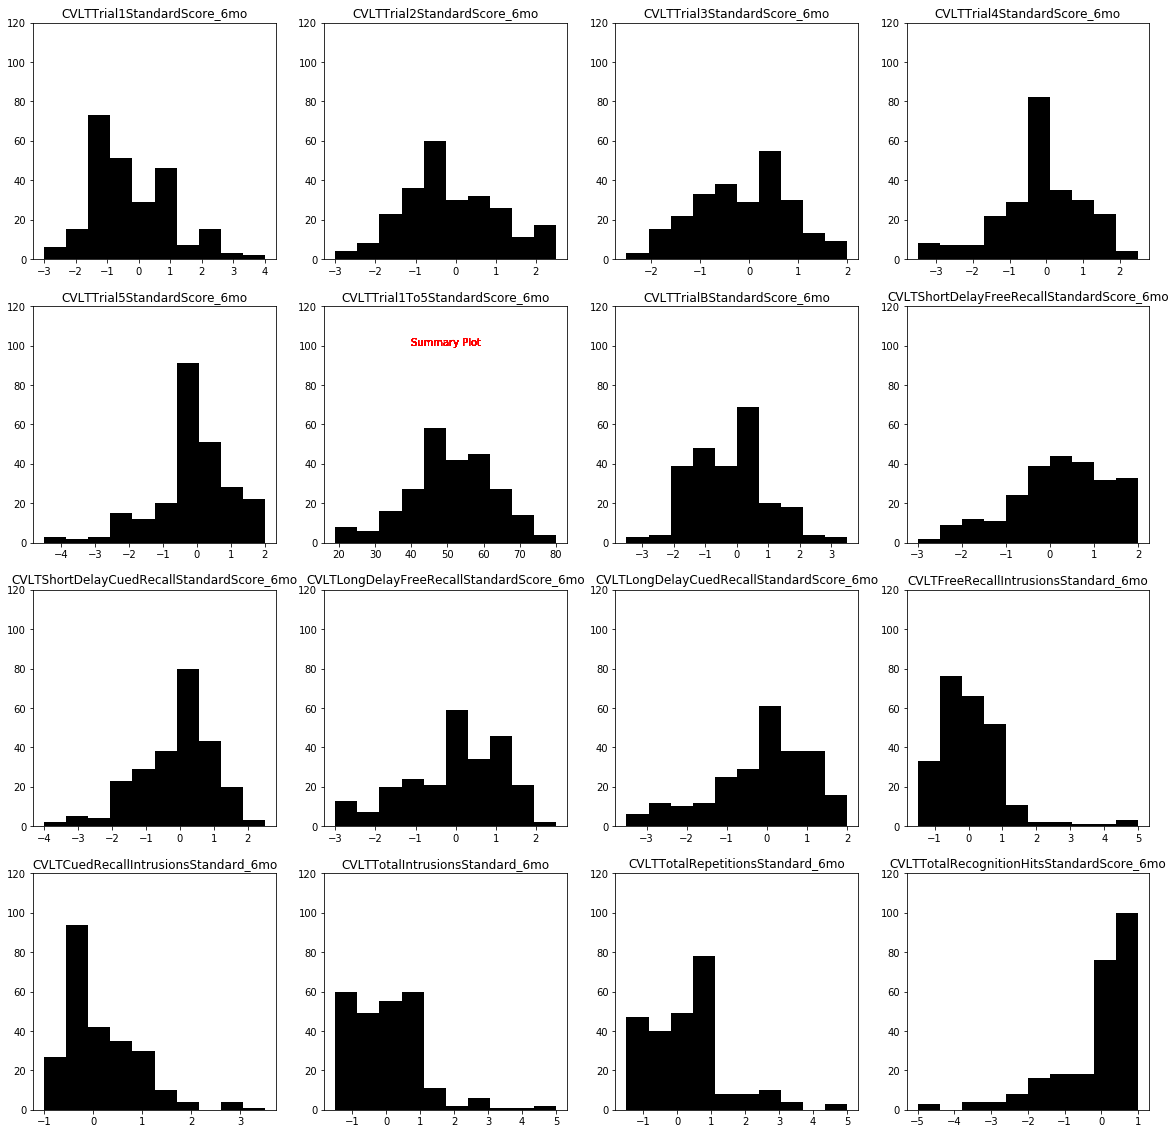

In [103]:

indices = [145,147,149,151,153,155,157,159,161,163,165,167,168,170,172,174]
fig, ax = plt.subplots(4,4, figsize=(20,20))
ax = ax.flatten()

count = 0
for ind, feature in zip(indices, cvlt_names):
    cvlt = oc[:,ind]
    ax[count].hist(cvlt, color='black')
    ax[count].set_title('{}'.format(feature))
    ax[count].set_ylim([0,120])
    ax[5].text(40,100,'Summary Plot', color='red')
    ax[6].text(-1,100,'Summary Plot', color='red')

        
    count += 1
plt.savefig('/Users/ahyeon/Desktop/activ misc/cvlt_hist.pdf')


In [ ]:
# other summaries
WAIS_PSI_Composite_6mo